In [ ]:
!pip install kaggle --upgrade # Kaggle API를 최신 버전으로 설치

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.14-py3-none-any.whl size=105119 sha256=4bcadb2e75af98117f09e081091ddec10bb918f4b46c1ea06507287fbc0a21df
  Stored in directory: /root/.cache/pip/wheels/d7/54/06/8a8f40cb39536605feb9acaacd0237a95eba39e5065e6392f4
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.12
    Uninstalling kaggle-1.6.12:
      Successfully uninstalled kaggle-1.6.12


In [ ]:
from google.colab import files
files.upload() # Kaggle API 토큰 파일(kaggle.json)을 업로드

KeyboardInterrupt: 

In [ ]:
!mkdir -p ~/.kaggle # Kaggle 폴더를 생성
!cp kaggle.json ~/.kaggle/ # 업로드한 kaggle.json 파일을 해당 폴더로 복사
!chmod 600 ~/.kaggle/kaggle.json # 권한을 설정
!ls -1ha kaggle.json # 파일이 제대로 폴더에 있는지 확인(존재하면 kaggle.json 파일의 이름을 출력)

kaggle.json


In [ ]:
! kaggle datasets download -d birdy654/deep-voice-deepfake-voice-recognition

Dataset URL: https://www.kaggle.com/datasets/birdy654/deep-voice-deepfake-voice-recognition
License(s): other
100% 3.67G/3.69G [00:52<00:00, 94.9MB/s]
100% 3.69G/3.69G [00:52<00:00, 75.3MB/s]


In [ ]:
!unzip deep-voice-deepfake-voice-recognition.zip

Archive:  deep-voice-deepfake-voice-recognition.zip
  inflating: DEMONSTRATION/DEMONSTRATION/linus-original-DEMO.mp3  
  inflating: DEMONSTRATION/DEMONSTRATION/linus-to-musk-DEMO.mp3  
  inflating: KAGGLE/AUDIO/FAKE/Obama-to-Biden.wav  
  inflating: KAGGLE/AUDIO/FAKE/Obama-to-Trump.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-Obama.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-Trump.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-linus.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-margot.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-musk.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-ryan.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-taylor.wav  
  inflating: KAGGLE/AUDIO/FAKE/linus-to-biden.wav  
  inflating: KAGGLE/AUDIO/FAKE/linus-to-margot.wav  
  inflating: KAGGLE/AUDIO/FAKE/linus-to-musk.wav  
  inflating: KAGGLE/AUDIO/FAKE/linus-to-obama.wav  
  inflating: KAGGLE/AUDIO/FAKE/linus-to-ryan.wav  
  inflating: KAGGLE/AUDIO/FAKE/linus-to-taylor.wav  
  inflating: KAGGLE/AUDIO/FAKE/linu

In [ ]:
!pip install resampy
import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # Jupyter 노트북에서 진행 상황을 보여주는 라이브러리
import IPython # 오디오 파일 재생을 위한 라이브러리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Reshape, MaxPooling2D, Dropout, Conv2D, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 9.4 MB/s eta 0:00:00


In [ ]:
audio_files_path = "KAGGLE/AUDIO/" # 데이터셋의 오디오 파일 경로를 설정
folders = os.listdir(audio_files_path) # 경로 내의 폴더 목록을 불러옴
print(folders) # 폴더 목록을 출력

['REAL', 'FAKE']


In [ ]:
real_audio = 'DEMONSTRATION/DEMONSTRATION/linus-original-DEMO.mp3'
fake_audio = 'DEMONSTRATION/DEMONSTRATION/linus-to-musk-DEMO.mp3'
print('Real Audio:')
IPython.display.Audio(real_audio)

Real Audio:


In [ ]:
print('Fake Audio:')
IPython.display.Audio(fake_audio)

Fake Audio:


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


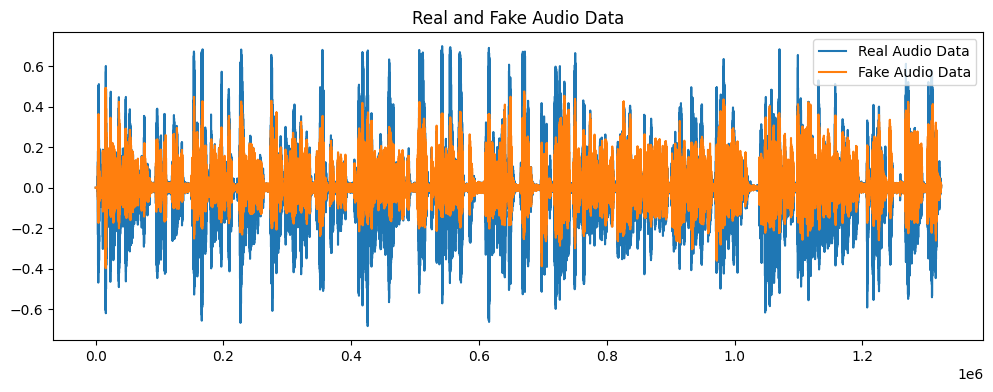

In [ ]:
# 오디오 파일 로드
# y, sr = librosa.load() : y는 로드된 오디오 파일의 시간 도메인 데이터, 각 요소는 샘플링된 오디오 신호의 샘플 값, sr은 샘플링 레이트
real_ad, real_sr = librosa.load(real_audio) # 실제 음성 데이터를 로드
fake_ad, fake_sr = librosa.load(fake_audio) # 딥페이크 음성 데이터를 로드
plt.figure(figsize=(12, 4))

plt.plot(real_ad, label='Real Audio Data')
plt.plot(fake_ad, label='Fake Audio Data')
plt.title('Real and Fake Audio Data')
plt.legend()
plt.show()

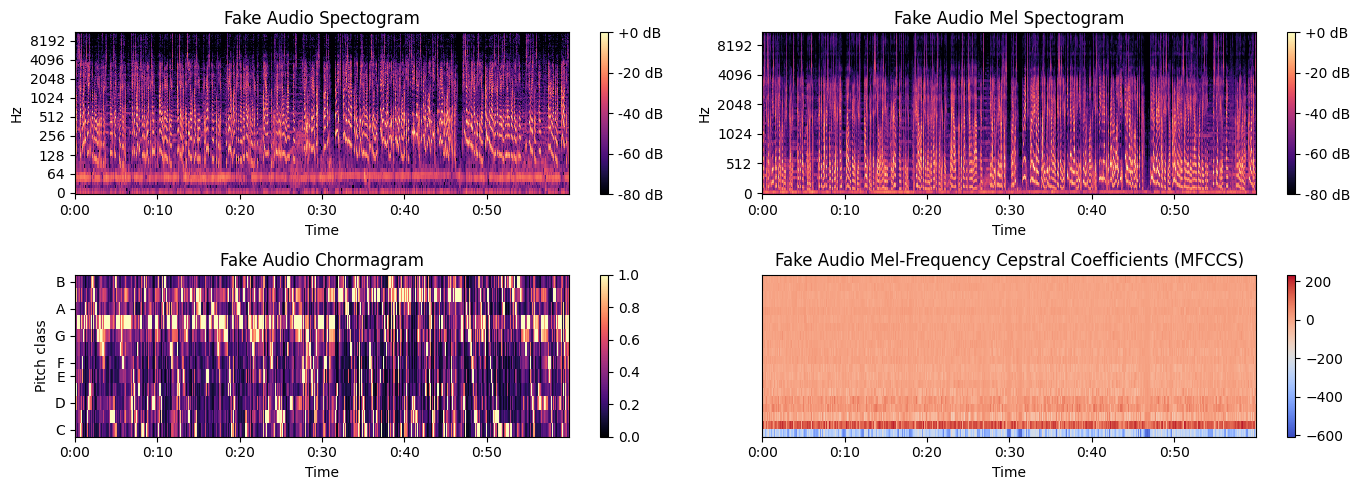

In [ ]:
# 스펙트로그램 생성
fake_spec = np.abs(librosa.stft(fake_ad))
fake_spec = librosa.amplitude_to_db(fake_spec, ref=np.max)

# 멜 스펙트로그램 생성
fake_mel_spect = librosa.feature.melspectrogram(y=fake_ad, sr=fake_sr)
fake_mel_spect = librosa.power_to_db(fake_mel_spect, ref=np.max)

# 크로마그램 생성
fake_chroma = librosa.feature.chroma_cqt(y=fake_ad, sr=fake_sr, bins_per_octave=36)

# MFCCs 생성
fake_mfcc = librosa.feature.mfcc(y=fake_ad, sr=fake_sr)

# 플롯 설정
plt.figure(figsize=(14, 5))

# 스펙트로그램 플롯
plt.subplot(2, 2, 1)
librosa.display.specshow(fake_spec, sr=fake_sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Fake Audio Spectogram')

# 멜 스펙트로그램 플롯
plt.subplot(2, 2, 2)
librosa.display.specshow(fake_mel_spect, sr=fake_sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Fake Audio Mel Spectogram')

# 크로마그램 플롯
plt.subplot(2, 2, 3)
librosa.display.specshow(fake_chroma, sr=fake_sr, x_axis='time', y_axis='chroma', vmin=0, vmax=1)
plt.colorbar()
plt.title('Fake Audio Chormagram')

# MFCCs 플롯
plt.subplot(2, 2, 4)
librosa.display.specshow(fake_mfcc, sr=fake_sr, x_axis='time')
plt.colorbar()
plt.title('Fake Audio Mel-Frequency Cepstral Coefficients (MFCCS)')

# 플롯 표시
plt.tight_layout()
plt.show()


In [ ]:
data = []
labels = []

for folder in folders:
    files = os.listdir(os.path.join(audio_files_path, folder)) # 각 폴더 내의 파일 목록을 가져옴
    for file in tqdm(files): # 파일 목록을 진행 상황과 함께 반복
        file_path = os.path.join(audio_files_path, folder, file) # 각 파일의 전체 경로
        audio, sample_rate = librosa.load(file_path, res_type="kaiser_fast") # 오디오 파일을 로드
        mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40) # MFCCs 추출
        mfccs_features_scaled = np.mean(mfccs_features.T, axis=0) # 평균 값을 계산하여 특성을 축소
        data.append(mfccs_features_scaled) # 데이터를 추가
        labels.append(folder) # 레이블을 추가

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

In [ ]:
x = np.array(data)
y = np.array(labels)

# 라벨 인코딩
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

xtrain, xtest, ytrain, ytest = train_test_split(x, y_encoded, test_size = 0.2)
print("훈련 세트의 크기:", xtrain.shape, ytrain.shape)
print("검증 세트의 크기:", xtest.shape, ytest.shape)

input_shape = xtrain.shape[1:]
num_labels = len(folders) # label의 개수는 folders에 있는 REAL과 FAKE 2개

input_shape

훈련 세트의 크기: (51, 40) (51,)
검증 세트의 크기: (13, 40) (13,)


(40,)

In [ ]:
model = Sequential()
model.add(Dense(32, input_shape=input_shape))
model.add(Activation("relu"))


model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.1))

model.add(Dense(32))
model.add(Activation("relu"))
model.add(Dropout(0.1))

model.add(Dense(num_labels))
model.add(Activation("softmax"))

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics  = 'accuracy')
history = model.fit(xtrain, ytrain, epochs=100, batch_size=3, validation_data=(xtest, ytest), verbose=1,
                    )

Epoch 1/100
17/17 [==============================] - 2s 16ms/step - loss: 8.7117 - accuracy: 0.6275 - val_loss: 2.4974 - val_accuracy: 0.9231
Epoch 2/100
17/17 [==============================] - 0s 6ms/step - loss: 4.5385 - accuracy: 0.8039 - val_loss: 0.7472 - val_accuracy: 0.9231
Epoch 3/100
17/17 [==============================] - 0s 6ms/step - loss: 2.1017 - accuracy: 0.7647 - val_loss: 1.1319 - val_accuracy: 0.9231
Epoch 4/100
17/17 [==============================] - 0s 6ms/step - loss: 1.8841 - accuracy: 0.8235 - val_loss: 0.6353 - val_accuracy: 0.9231
Epoch 5/100
17/17 [==============================] - 0s 6ms/step - loss: 2.0870 - accuracy: 0.7255 - val_loss: 0.6084 - val_accuracy: 0.9231
Epoch 6/100
17/17 [==============================] - 0s 9ms/step - loss: 2.6134 - accuracy: 0.8039 - val_loss: 0.6155 - val_accuracy: 0.9231
Epoch 7/100
17/17 [==============================] - 0s 8ms/step - loss: 2.4167 - accuracy: 0.7255 - val_loss: 0.3463 - val_accuracy: 0.8462
Epoch 8/100


In [ ]:
loss, accuracy = model.evaluate(xtest, ytest)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

NameError: name 'model' is not defined